In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

In [8]:
BASE_DIR = '..'
COUNTRY = 'malawi_2016'
COUNTRY_DIR = os.path.join(BASE_DIR, 'countries', COUNTRY)
PROCESSED_DIR = os.path.join(COUNTRY_DIR, 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')

# these relate to the current country in question
IMAGE_DIR = os.path.join(COUNTRY_DIR, 'images')
RESULTS_DIR = os.path.join(COUNTRY_DIR, 'results')
CNN_SAVE_FEATS_DIR = os.path.join(RESULTS_DIR, 'cnn')

In [3]:
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(CNN_SAVE_FEATS_DIR, exist_ok=True)

# Feature extract with CNN
If you have run this step before, you can skip it and run the commented out code in the next section to quick-start.

In [4]:
df_images = pd.read_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'))

In [15]:
df_images.head()

,im_lat,im_lon,cluster_lat,cluster_lon,cons_pc,nightlights,nightlights_bin,image_name
0,-17.116666,35.199999,-17.095150,35.217213,1.477796,0.0,1,-17.116666298200016_35.1999991392.png
1,-17.050000,35.216666,-17.095150,35.217213,1.477796,0.0,1,-17.04999963180002_35.216665805800005.png
2,-17.116666,35.224999,-17.095150,35.217213,1.477796,0.0,1,-17.116666298200016_35.22499913910002.png
3,-17.050000,35.241666,-17.095150,35.217213,1.477796,0.0,1,-17.04999963180002_35.241665805699995.png
4,-17.116666,35.091666,-17.092351,35.114643,1.314741,0.0,1,-17.116666298200016_35.0916658063.png


In [23]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

def filename_to_im_tensor(file):
    im = plt.imread(file)[:,:,:3]
    im = transformer(im)
    return im[None].to(device)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} as backend')
model = torch.load(os.path.join(MODEL_DIR, 'trained_model.pt'), map_location=device)

Using cuda as backend


In [10]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)

In [11]:
# rip off the final layers
model.classifier = model.classifier[:4]

In [12]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)

In [16]:
unique_ims = df_images.drop_duplicates(subset=['image_name'])
unique_ims.shape

(11321, 8)

In [19]:
feats = np.zeros((unique_ims.shape[0],4096))
ims = unique_ims['image_name'].values

## Forward Pass

In [26]:
model.eval()
i = 0
batch_size = 4

# this approach uses batching and should offer a speed-up over passing one image at a time by nearly 10x
# runtime should be 5-7 minutes vs 45+ for a full forward pass
while i + batch_size < len(ims):
    ims_as_tensors = torch.cat([filename_to_im_tensor(os.path.join(IMAGE_DIR, ims[i+j])) for j in range(batch_size)], 0)
    feats[i:i+batch_size,:] = model(ims_as_tensors).cpu().detach().numpy()
    i += batch_size
    if i % 100 == 0:
        print(i, end=', ')

# does the final batch of remaining images
if len(ims) - i != 0:
    rem = len(ims) - i
    ims_as_tensors = torch.cat([filename_to_im_tensor(os.path.join(IMAGE_DIR, ims[i+j])) for j in range(rem)], 0)
    feats[i:i+rem,:] = model(ims_as_tensors).cpu().detach().numpy()
    i += rem

In [27]:
feats

array([[ 0.20969284,  0.83891308,  0.38676089, ...,  0.24679327,
         0.18794033, -0.19586143],
       [-0.20543927,  0.32481244,  0.34356976, ..., -0.06038708,
         0.3685053 , -0.44405195],
       [-0.2345438 ,  0.18820927,  0.18627386, ...,  0.08569382,
         0.33346465, -0.37387154],
       ...,
       [-0.53970993,  0.77068257, -0.24382259, ...,  0.60237354,
         0.86922705, -0.50340468],
       [-0.16981718,  0.24546364,  0.17454211, ...,  0.08013973,
         0.19938812, -0.55748087],
       [-0.22830302,  0.33271122,  0.16618423, ...,  0.26861453,
         0.28568718, -0.06189717]])

In [28]:
np.save(os.path.join(CNN_SAVE_FEATS_DIR, 'forward_feats.npy'), feats)

In [30]:
unique_ims = unique_ims[['image_name']]
# this will be joined with the main df to show what index you should be looking at in feats
unique_ims['feat_index'] = np.arange(len(unique_ims))

/home/jupyter/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
unique_ims.head()

,image_name,feat_index
0,-17.116666298200016_35.1999991392.png,0
1,-17.04999963180002_35.216665805800005.png,1
2,-17.116666298200016_35.22499913910002.png,2
3,-17.04999963180002_35.241665805699995.png,3
4,-17.116666298200016_35.0916658063.png,4


In [33]:
df_consumption = pd.merge(left=df_images, right=unique_ims, on='image_name')

In [34]:
df_consumption.head()

,im_lat,im_lon,cluster_lat,cluster_lon,cons_pc,nightlights,nightlights_bin,image_name,feat_index
0,-17.116666,35.199999,-17.095150,35.217213,1.477796,0.0,1,-17.116666298200016_35.1999991392.png,0
1,-17.050000,35.216666,-17.095150,35.217213,1.477796,0.0,1,-17.04999963180002_35.216665805800005.png,1
2,-17.116666,35.224999,-17.095150,35.217213,1.477796,0.0,1,-17.116666298200016_35.22499913910002.png,2
3,-17.050000,35.241666,-17.095150,35.217213,1.477796,0.0,1,-17.04999963180002_35.241665805699995.png,3
4,-17.116666,35.091666,-17.092351,35.114643,1.314741,0.0,1,-17.116666298200016_35.0916658063.png,4


In [36]:
df_consumption.shape

(25895, 9)

In [37]:
group = df_consumption.groupby(['cluster_lat', 'cluster_lon'])
num_clusts = len(group)
num_clusts

753

## Aggregate Features

In [41]:
x = np.zeros((num_clusts, 4096))
y = []
clusters = []

In [42]:
# this goes through each cluster group and finds all images that are in the cluster
# it aggregates the features for those images across the cluster
for i, g in enumerate(group):
    lat, long = g[0]
    im_sub = df_consumption[(df_consumption['cluster_lat'] == lat) & (df_consumption['cluster_lon'] == long)].reset_index(drop=True)
    agg_feats = np.zeros((len(im_sub), 4096))
    for j, d in im_sub.iterrows():
        agg_feats[j,:] = feats[d.feat_index]
    agg_feats = agg_feats.mean(axis=0) # averages the features across all images in the cluster
    
    x[i,:] = agg_feats
    y.append(g[1]['cons_pc'].values[0])
    clusters.append([lat, long])

In [43]:
np.save(os.path.join(CNN_SAVE_FEATS_DIR, 'cluster_feats.npy'), x)
pickle.dump(clusters, open(os.path.join(CNN_SAVE_FEATS_DIR, 'cluster_order.pkl'), 'wb'))

# Predict Consumption

In [4]:
# x = np.load(os.path.join(CNN_SAVE_FEATS_DIR, 'cluster_feats.npy'))
# clusters = pickle.open(open(os.path.join(CNN_SAVE_FEATS_DIR, 'cluster_order.pkl'), 'rb'))
# df_clusters = pd.read_csv(os.path.join(PROCESSED_DIR, 'clusters.csv'))
# lookup = df_clusters.set_index(['lat', 'lon'])
# y = []
# for lat, lon = clusters:
#     assert lat, lon in lookup
#     y.append(lookup.loc[lat, lon]['cons_pc'])
# y = np.array(y)
# y_log = np.log(y)


In [44]:
# This is a bunch of code from the Jean et al Github that is modified to work with Python3 and our data

import numpy as np
import pandas as pd
import random
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
import seaborn as sns


def predict_consumption(
    X, y, k=5, k_inner=5, points=10,
        alpha_low=1, alpha_high=5, margin=0.25):
    """
    Plots predicted consumption
    """
    y_hat, r2 = run_cv(X, y, k, k_inner, points, alpha_low, alpha_high)
    return X, y, y_hat, r2


def run_cv(X, y, k, k_inner, points, alpha_low, alpha_high, randomize=False):
    """
    Runs nested cross-validation to make predictions and compute r-squared.
    """
    alphas = np.logspace(alpha_low, alpha_high, points)
    r2s = np.zeros((k,))
    y_hat = np.zeros_like(y)
    kf = KFold(n_splits=k, shuffle=True)
    fold = 0
    for train_idx, test_idx in kf.split(X):
        r2s, y_hat, fold = evaluate_fold(
            X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
            randomize)
    return y_hat, r2s.mean()


def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    X_scaler = StandardScaler(with_mean=True, with_std=False)
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test


def train_and_predict_ridge(alpha, X_train, y_train, X_test):
    """
    Trains ridge model and predicts test set.
    """
    ridge = linear_model.Ridge(alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(X_test)
    return y_hat


def predict_inner_test_fold(X, y, y_hat, train_idx, test_idx, alpha):
    """
    Predicts inner test fold.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = scale_features(X_train, X_test)
    y_hat[test_idx] = train_and_predict_ridge(alpha, X_train, y_train, X_test)
    return y_hat


def find_best_alpha(X, y, k_inner, alphas):
    """
    Finds the best alpha in an inner CV loop.
    """
    kf = KFold(n_splits=k_inner, shuffle=True)
    best_alpha = 0
    best_r2 = 0
    for idx, alpha in enumerate(alphas):
        y_hat = np.zeros_like(y)
        for train_idx, test_idx in kf.split(X):
            y_hat = predict_inner_test_fold(
                X, y, y_hat, train_idx, test_idx, alpha)
        r2 = stats.pearsonr(y, y_hat)[0] ** 2
        if r2 > best_r2:
            best_alpha = alpha
            best_r2 = r2
    print('best alpha', best_alpha)
    return best_alpha


def evaluate_fold(
    X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
        randomize):
    """
    Evaluates one fold of outer CV.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    if randomize:
        random.shuffle(y_train)
    best_alpha = find_best_alpha(X_train, y_train, k_inner, alphas)
    X_train, X_test = scale_features(X_train, X_test)
    y_test_hat = train_and_predict_ridge(best_alpha, X_train, y_train, X_test)
    r2 = stats.pearsonr(y_test, y_test_hat)[0] ** 2
    r2s[fold] = r2
    y_hat[test_idx] = y_test_hat
    return r2s, y_hat, fold + 1


In [45]:
y = np.array(y)
y_log = np.log(y)

In [46]:
_, _, y_hat_log, r2 = predict_consumption(x, y_log)
r2

best alpha 1668.100537200059
best alpha 215.44346900318823
best alpha 215.44346900318823
best alpha 1668.100537200059
best alpha 599.4842503189409


0.45423189342060716

In [47]:
_, _, y_hat, r2 = predict_consumption(x, y)
r2

best alpha 1668.100537200059
best alpha 1668.100537200059
best alpha 1668.100537200059
best alpha 4641.588833612777
best alpha 1668.100537200059


0.3204953391916489

In [48]:
n_train = int(0.7*(len(x))) # let's use 70% of the data for training
inds = np.arange(len(x))
train_ind = np.random.choice(inds, n_train, replace=False)
valid_ind = np.delete(inds, train_ind)

train_x = x[train_ind]
valid_x = x[valid_ind]

train_y = y_log[train_ind]
valid_y = y_log[valid_ind]

ss = StandardScaler() # standardize features
train_x = ss.fit_transform(train_x)
valid_x = ss.transform(valid_x)

In [49]:
ridge = linear_model.Ridge(alpha=70) # the best alphas printed suggest using a high alphas
ridge.fit(train_x, train_y)
ridge.score(train_x, train_y)

0.74093474344636

In [50]:
ridge.score(valid_x, valid_y)

0.37543900498048244

In [53]:
preds = y_hat_log
valid_y = y_log

Text(0.5, 1.0, 'Malawi Results')

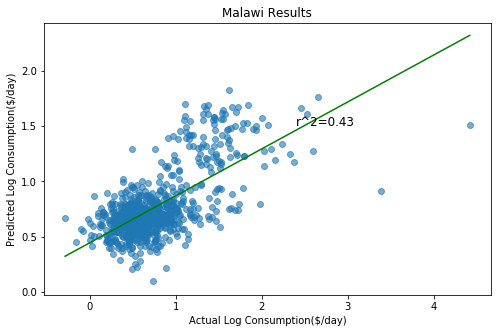

In [54]:
plt.figure(figsize=(8,5))
plt.scatter(valid_y, preds, alpha=0.6)
plt.plot(np.unique(valid_y), np.poly1d(np.polyfit(valid_y, preds, 1))(np.unique(valid_y)), color='g')
plt.text(2.4, 1.5, 'r^2=0.43', size=12)
plt.xlabel('Actual Log Consumption($/day)')
plt.ylabel('Predicted Log Consumption($/day)')
plt.title('Malawi Results')